In [1]:
import numpy as np
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Chapter 03

In this chapter we focus on building an intuition between causal concepts and linear regression. Next, we move to a comparison between observational and interventional distributions and show why and how they might be different. Finally, we introduce the concept of structural models. Structural models will naturally lead us to the concept of graphical models in the next chapter.

## Regression

Let's build a model according to the followingh specification:

$$\Large \hat{y}_i = 1.12 + 0.93x_i + 0.5 \epsilon_i$$ 

where $\epsilon \sim \mathcal{N}(0, 1)$

In [3]:
# Set the seed for reproducibility
np.random.seed(45)

# No. of samples
N_SAMPLES = 5000

# Define true model parameters
alpha = 1.12
beta = 0.93
epsilon = np.random.randn(N_SAMPLES)

# Generate X
X = np.random.randn(N_SAMPLES)

# Compute Y
y = alpha + beta * X + 0.5 * epsilon

# Statsmodel models require us to add constant
X = sm.add_constant(X)

print(X[:5, :])

[[ 1.          0.11530002]
 [ 1.         -0.43617719]
 [ 1.         -0.54138887]
 [ 1.         -1.64773122]
 [ 1.         -0.32616934]]


In [4]:
# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 1.681e+04
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:56:11   Log-Likelihood:                -3615.0
No. Observations:                5000   AIC:                             7234.
Df Residuals:                    4998   BIC:                             7247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1243      0.007    159.391      0.0

In [5]:
# Generate predictions
y_pred = fitted_model.predict(X)

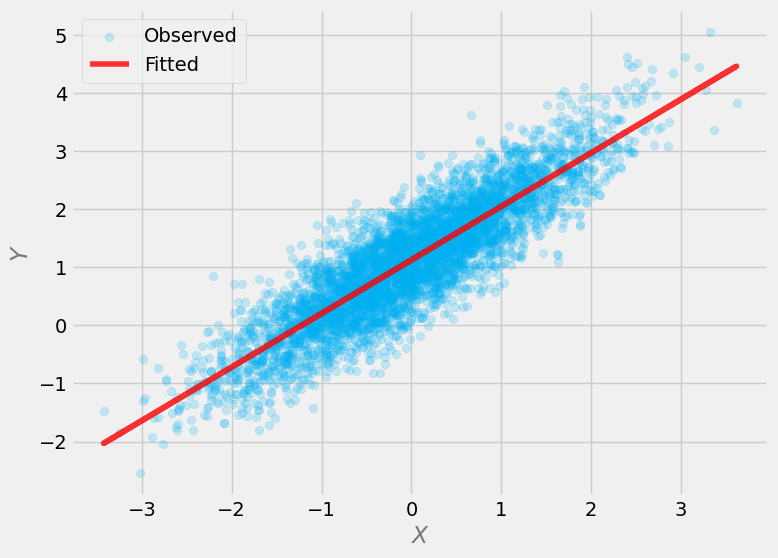

In [6]:
# Assuming 'X', 'y', 'y_pred', and 'COLORS' are defined as needed
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 1], y, color=COLORS[0], label='Observed', alpha=0.2)
line = plt.plot(X[:, 1], y_pred, color=COLORS[1], label='Fitted', alpha=0.8)
plt.xlabel('$X$', alpha=0.5)
plt.ylabel('$Y$', alpha=0.5)

# Create the legend manually to control handle transparency
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles, labels)

for handle in legend.get_patches():  # Use get_lines() if your legend consists of lines
    handle.set_alpha(0.8)

plt.show()


### Reversed model

Now we're going to reverse the ordering of variables and regress $X$ on $Y$.

In [7]:
# Let's remove the constant (now X becomes our target variable) 
x_rev = X[:, 1]

# Let's add constant (now Y becomes our predictor)
Y_rev = sm.add_constant(y)

In [8]:
# Instantiate the model and fit it
model_rev = sm.OLS(x_rev, Y_rev)
fitted_model_rev = model_rev.fit()

# Print results summary
print(fitted_model_rev.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 1.681e+04
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:56:12   Log-Likelihood:                -3375.0
No. Observations:                5000   AIC:                             6754.
Df Residuals:                    4998   BIC:                             6767.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9441      0.010    -96.048      0.0

In [9]:
# Generate predictions
x_pred_rev = fitted_model_rev.predict(Y_rev)

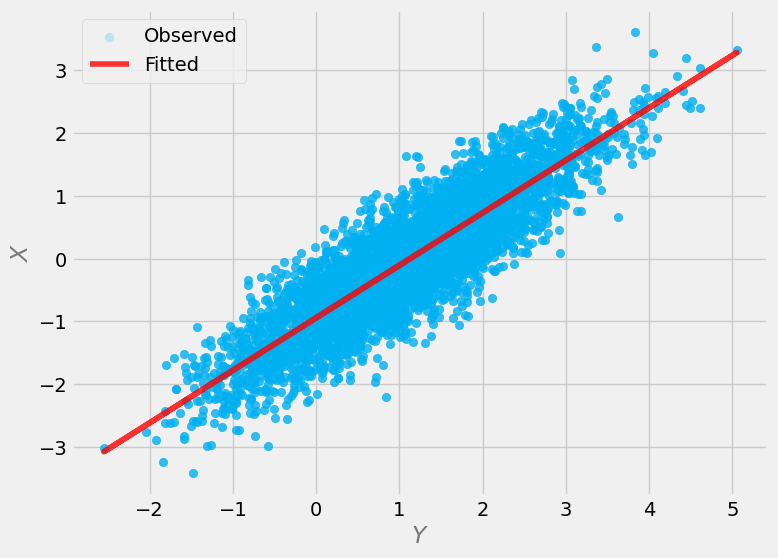

In [10]:
# Assuming 'Y_rev', 'x_rev', 'x_pred_rev', and 'COLORS' are defined as needed
plt.figure(figsize=(8, 6))
plt.scatter(Y_rev[:, 1], x_rev, color=COLORS[0], label='Observed', alpha=0.2)
plt.plot(Y_rev[:, 1], x_pred_rev, color=COLORS[1], label='Fitted', alpha=0.8)
plt.xlabel('$Y$', alpha=0.5)
plt.ylabel('$X$', alpha=0.5)

# Create the legend manually to control handle transparency
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles, labels)

# Set opacity for the legend handles using a loop to ensure it applies correctly
for handle in handles:
    handle.set_alpha(0.8)


plt.show()


## Should we always control for all available covariates?

### Example

#### Visualize the model

To correctly render the graphs you need to install graphviz backend. 

More details: https://pypi.org/project/graphviz/

In [11]:
import graphviz

In [12]:
# Create a directed graph
g_1 = graphviz.Digraph(format='png')

# Add nodes
nodes_1 = ['A', 'X', 'B', 'Y']
[g_1.node(n) for n in nodes_1]

g_1.edges(['AX', 'XB', 'AY', 'YB'])

In [13]:
# Render for print
g_1.render('img/ch_03_graph_01')

'img/ch_03_graph_01.png'

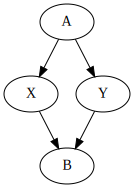

In [14]:
# Display the graph
g_1

In [15]:
# Set random seed for reproducibility
np.random.seed(45)

# Define the sample size
N_SAMPLES = 1000

# Build the graph (note that the coefficients are arbitrarily chosen)
a = np.random.randn(N_SAMPLES)
x = 2 * a + 0.5 * np.random.randn(N_SAMPLES)
y = 2 * a + 0.5 * np.random.randn(N_SAMPLES)
b = 1.5 * x + 0.75 * y

In [16]:
# Define four model variants
variants = [
    [x],
    [x, a],
    [x, b],
    [x, a, b]
]

# Fit models iteratively and store the results
results = []
for variant in variants:
    X = sm.add_constant(np.stack(variant).T)
    
    # Instantiate the model and fit it
    model = sm.OLS(y, X)
    fitted_model = model.fit()
    
    results.append((fitted_model.params, fitted_model.pvalues))
    
    print(f'Params: {fitted_model.params.round(3)}')
    print(f'p-vals: {fitted_model.pvalues.round(3)}')
    print(f'Signif: {fitted_model.pvalues <= .05}\n')

Params: [-0.02   0.947]
p-vals: [0.359 0.   ]
Signif: [False  True]

Params: [-0.011  0.014  1.967]
p-vals: [0.488 0.657 0.   ]
Signif: [False False  True]

Params: [-0.    -2.     1.333]
p-vals: [0.005 0.    0.   ]
Signif: [ True  True  True]

Params: [ 0.    -2.     0.     1.333]
p-vals: [0. 0. 0. 0.]
Signif: [ True  True  True  True]



In [17]:
# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.150e+33
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:56:12   Log-Likelihood:                 33532.
No. Observations:                1000   AIC:                        -6.706e+04
Df Residuals:                     996   BIC:                        -6.704e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.527e-16    2.1e-17      7.270      0.0

## Regression and structural models

In [18]:
# Create a directed graph
g_2 = graphviz.Digraph(
    format='png',
    graph_attr={
        'rankdir':'LR', 
        'ranksep': '.6',
        'nodesep': '1.5'
    })

# Add nodes
nodes_2 = ['A', 'X', 'Y']
[g_2.node(n) for n in nodes_2]

g_2.edges(['AY', 'AX', 'XY'])

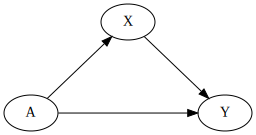

In [19]:
g_2

In [20]:
# Render for print
g_2.render('img/ch_03_graph_02')

'img/ch_03_graph_02.png'

In [21]:
# Set random seed for reproducibility
np.random.seed(45)

# Define the sample size
N_SAMPLES = 1000

# Define the SCM
a = np.random.randn(N_SAMPLES)
x = 2 * a + .7 * np.random.randn(N_SAMPLES)
y = 2 * a + 3 * x + .75 * x**2

In [22]:
# Statsmodel models require us to add constant
X = sm.add_constant(np.stack([x, x**2, a]).T)

# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary(xname=['const', 'x', 'x^2', 'a']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.760e+33
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:56:12   Log-Likelihood:                 31962.
No. Observations:                1000   AIC:                        -6.392e+04
Df Residuals:                     996   BIC:                        -6.390e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.331e-16   1.23e-16     -2.700      0.0